In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [3]:
import seaborn as sns
import datetime
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

In [4]:
a = np.array([0, 0.22, -0.18, 0.08])
b = np.array([1, 0.5, 0.25, 0.25])

In [5]:
def add_intercept(X):
    b = np.ones([X.shape[0], 1])
    return np.concatenate([b, X], axis=1)

In [6]:
def MSE(X, y):
    theta = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, y)).reshape(X.shape[1],)
    return theta

In [7]:
def RMSE(alpha, beta, X, y):
    theta_i = np.ones((alpha.size,1))
    P_i = np.identity(alpha.size)*beta
    for i,x in enumerate(X):
        x = x.reshape((1,x.size))
        P_i_1 = P_i - np.dot(np.dot(P_i,x.T),np.dot(x,P_i))\
        / (1+np.dot(np.dot(x,P_i),x.T))
        theta_i_1 = theta_i + np.dot(np.dot(P_i_1,x.T),(y[i] - np.dot(x,theta_i)))
        P_i = P_i_1
        theta_i = theta_i_1
    return theta_i.reshape((theta_i.shape[0],))
    

In [8]:
def predict(X, theta):
    return np.dot(X,theta)

In [9]:
def loss(X, y, theta):
    return (predict(X,theta) - y)**2

In [10]:
def r_square(y_true, y_pred):
    return np.var(y_pred)/np.var(y_true)

In [11]:
def ika(y_true, y_pred, p, q):
    n = p + q + 1
    return y_true.shape[0]*np.log(np.sum((y_true - y_pred)**2)) + 2*n

In [12]:
def auto_reg_mov_avg(y,epsilon,ar_weights=a,ma_weights=b,p=3,q=3):
    arma = np.ones((y.shape[0],), dtype='float64')
    arma = np.array([y[i] if i<max(p+1,q+1)-1 else \
                      ar_weights[0]+np.dot(y[i-p:i],ar_weights[1:p+1][::-1]) + \
                      ma_weights[0]*epsilon[i]+np.dot(epsilon[i-q:i],ma_weights[1:q+1][::-1])\
                         for i in range(len(epsilon))])
    return arma

In [13]:
def generate_y(epsilon, ar_weights=a,ma_weights=b,p=3,q=3):
    y = np.random.normal(size=epsilon.shape[0])
    for i in range(y.shape[0]):
        y[i] = epsilon[i] if i<max(p+1,q+1)-1 else\
                ar_weights[0]+np.dot(y[i-p:i],ar_weights[1:p+1][::-1]) + \
                ma_weights[0]*epsilon[i]+np.dot(epsilon[i-q:i],ma_weights[1:q+1][::-1])
    return y

In [14]:
def compose_X(y, epsilon, p=3, q=3):
    X = []
    X = np.array([np.concatenate([y[i-p:i][::-1],np.array([epsilon[i]]),epsilon[i-q:i][::-1]]) for i in range(len(epsilon)) if i>=max(p+1,q+1)-1])
    return add_intercept(X)

In [15]:
epsilon = np.random.normal(size=2000)
y = generate_y(epsilon, ar_weights=a, ma_weights=b, p=3, q=3)

with open('y.txt') as f_y:
    y = np.loadtxt(f_y.name)

with open('v.txt') as f_v:
    epsilon = np.loadtxt(f_v.name)

y.shape,epsilon.shape

y = np.concatenate([epsilon[:3],y])

In [16]:
y.shape,epsilon.shape

((2000,), (2000,))

fig = plt.figure(figsize=(15,10))
plt.scatter(np.arange(1,epsilon.shape[0]+1),epsilon, label='White Noise')
plt.plot(np.arange(1,epsilon.shape[0]+1),y, label='Time Siries',c='r')
plt.xlabel('t')
plt.ylabel('y')
plt.legend()

In [17]:
X = compose_X(y, epsilon, p=3, q=3)
start = epsilon.shape[0] - X.shape[0]
theta_mse = MSE(X,y[start:])

In [18]:
X.shape

(1997, 8)

In [19]:
a_ = theta_mse[:4]
b_ = theta_mse[4:]
y_ = predict(X, theta_mse)
print(theta_mse[:4])
print(theta_mse[4:])

[ -1.69135539e-17   2.20000000e-01  -1.80000000e-01   8.00000000e-02]
[ 1.    0.5   0.25  0.25]


In [20]:
np.mean(loss(X,y[start:],theta_mse))

1.1816067535636022e-28

In [21]:
y_pred_mse = predict(X,theta_mse)
start = epsilon.shape[0] - X.shape[0]
print ika(y[start:],y_pred_mse,p=3,q=3)
print r_square(y[start:],y_pred_mse)

-113228.093887
1.0


fig = plt.figure(figsize=(15,10))
plt.plot(np.arange(1,epsilon.shape[0]+1),y, label='Time Series Real')
plt.plot(np.arange(1,epsilon.shape[0]+1),auto_reg_mov_avg(y, epsilon, ar_weights=a_, ma_weights=b_, p=3, q=3),c='r', label='Time Series Predicted')
plt.xlabel('t')
plt.ylabel('y')
plt.legend()

In [22]:
theta_rmse = RMSE(np.zeros(X.shape[1]),600,X,y[start:])

In [23]:
theta_rmse

array([  8.39103733e-07,   2.19956888e-01,  -1.80002168e-01,
         8.00142355e-02,   1.00000008e+00,   5.00043460e-01,
         2.50033755e-01,   2.49997831e-01])

In [24]:
a = np.array([0, 0.22, -0.18, 0.08])
b = np.array([1, 0.5, 0.25, 0.25])

In [25]:
np.sum(loss(X,y[start:],theta_rmse))

3.8605772878424546e-08

In [26]:
k_iter = np.arange(15,101,5)
coeff_mse = []
coeff_rmse = []

In [27]:
for i in k_iter:
    epsilon = np.random.normal(size=i)
    y = generate_y(epsilon, ar_weights=a, ma_weights=b, p=3, q=3)
    X = compose_X(y, epsilon, p=3, q=3)
    start = epsilon.shape[0] - X.shape[0]
    theta_mse = MSE(X,y[start:])
    theta_rmse = RMSE(np.zeros(X.shape[1]),60,X,y[start:])
    coeff_mse.append(theta_mse)
    coeff_rmse.append(theta_rmse)

In [28]:
coefs = {'a0':0,'a1':0.22,'a2':-0.18,'a3':0.08,'1':1,'b1':0.5,'b2':0.25,'b3':0.25}
num = {'a0':0,'a1':1,'a2':2,'a3':3,'1':4,'b1':5,'b2':6,'b3':7}

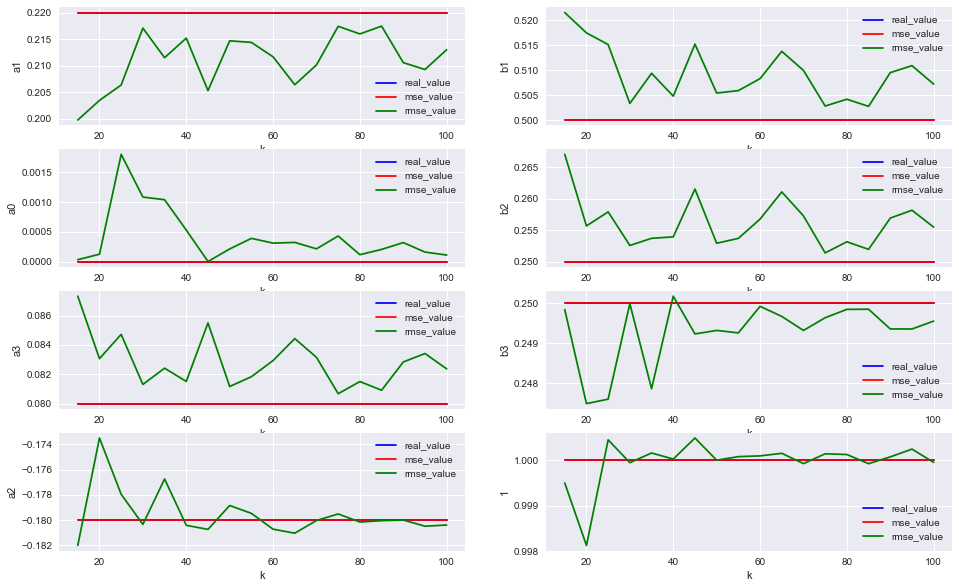

In [29]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 10))
for k, coef in enumerate(coefs): 
    axes[int(k % 4), int(k / 4)].plot(k_iter, np.ones(k_iter.shape)*coefs[str(coef)], c='b')
    axes[int(k % 4), int(k / 4)].plot(k_iter, np.array(coeff_mse)[:,num[str(coef)]], c='r')
    axes[int(k % 4), int(k / 4)].plot(k_iter, np.array(coeff_rmse)[:,num[str(coef)]], c='g')
    axes[int(k % 4), int(k / 4)].legend(['real_value','mse_value','rmse_value'])
    axes[int(k % 4), int(k / 4)].set_xlabel('k')
    axes[int(k % 4), int(k / 4)].set_ylabel(coef)

In [30]:
params = []
errors = []

In [31]:
epsilon = np.random.normal(size=2000)
y = generate_y(epsilon, ar_weights=a, ma_weights=b, p=3, q=3)
X = compose_X(y, epsilon, p=3, q=3)
start = epsilon.shape[0] - X.shape[0]
print(start)
for i in range(1,4):
    for j in range(1,4):
        print(i,j)
        error = []
        params.append((i,j))
        X = compose_X(y[start:], epsilon[start:], p=i, q=j)
        start_ = epsilon[start:].shape[0] - X.shape[0] + start
        print(start_)
        theta_mse = MSE(X,y[start_:])
        theta_rmse = RMSE(np.zeros(X.shape[1]),60,X,y[start_:])
        y_pred_mse = predict(X,theta_mse)
        y_pred_rmse = predict(X,theta_rmse)
        error.append(np.sum(loss(X,y[start_:], theta_mse)))
        error.append(r_square(y[start_:],y_pred_mse))
        error.append(ika(y[start_:],y_pred_mse,p=i,q=j))
        error.append(np.sum(loss(X,y[start_:], theta_rmse)))
        error.append(r_square(y[start_:],y_pred_rmse))
        error.append(ika(y[start_:],y_pred_rmse,p=i,q=j))
        errors.append(error)

3
(1, 1)
4
(1, 2)
5
(1, 3)
6
(2, 1)
5
(2, 2)
5
(2, 3)
6
(3, 1)
6
(3, 2)
6
(3, 3)
6


errors

In [33]:
err = pd.DataFrame(index=params,data=errors,columns=['S_mse','R^2_mse','IKA_mse','S_rmse','R^2_rmse','IKA_rmse'])
err.head()

,S_mse,R^2_mse,IKA_mse,S_rmse,R^2_rmse,IKA_rmse
"(1, 1)",64.404103,0.980138,8319.693974,64.404103,0.980143,8319.693980
"(1, 2)",46.186383,0.985754,7654.206625,46.186386,0.985755,7654.206739
"(1, 3)",2.160822,0.999333,1546.354824,2.160824,0.999340,1546.355956
"(2, 1)",21.746034,0.993293,6151.465633,21.746035,0.993295,6151.465697
"(2, 2)",18.648101,0.994248,5846.859966,18.648102,0.994252,5846.860005


In [34]:
writer = pd.ExcelWriter('errors.xlsx')
err.to_excel(writer,'Sheet1')
writer.save()

In [35]:
labels = ['S','R^2','IKA']

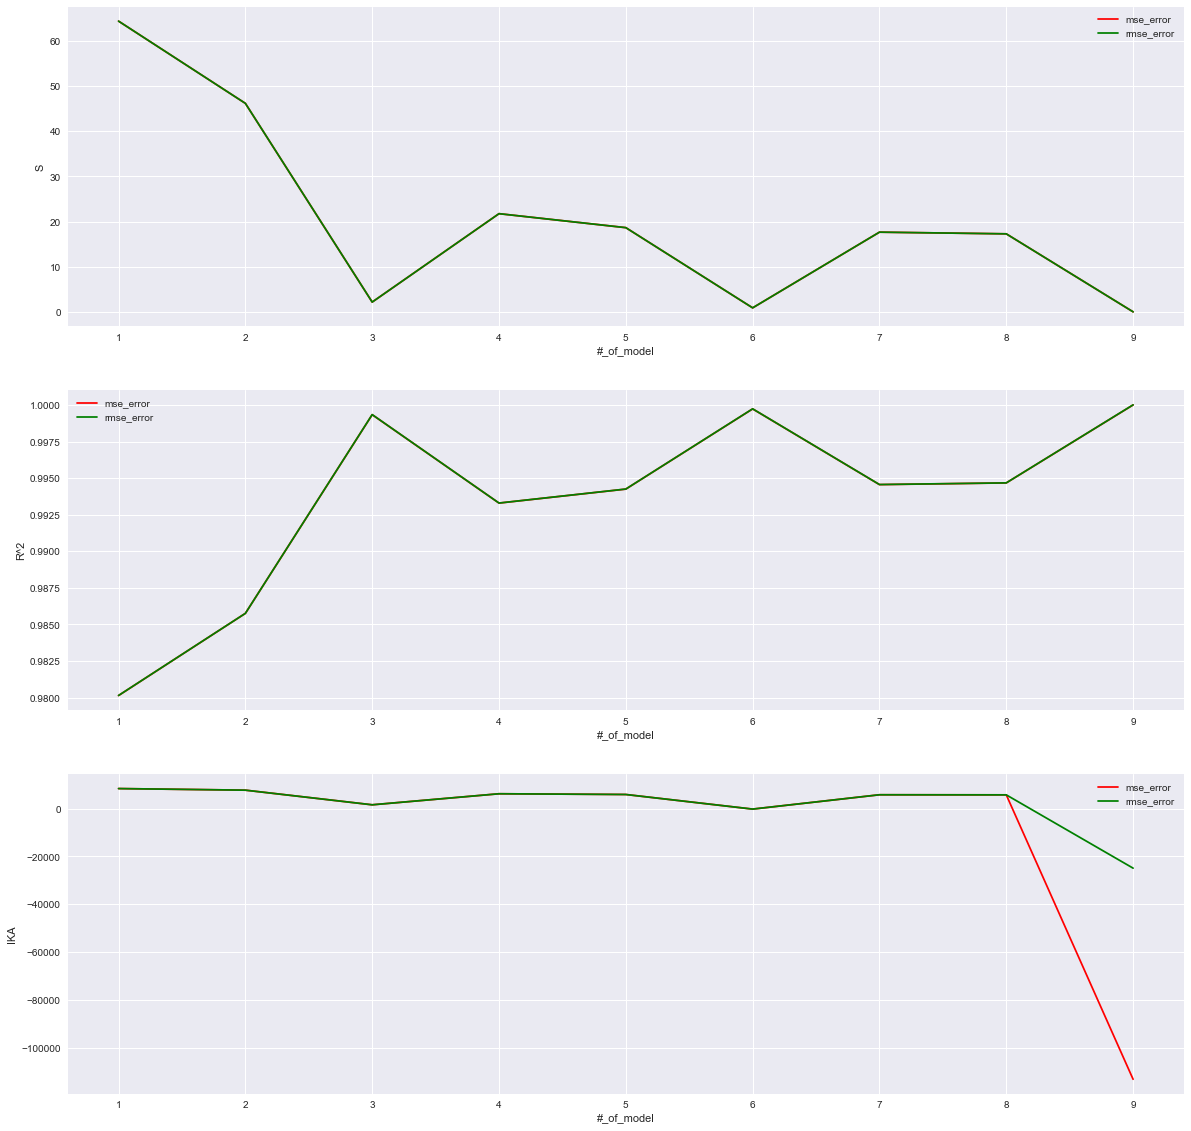

In [36]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 20))
for idx, feat in  enumerate(err.columns):
    if idx>2:
        continue
    axes[int(idx / 1)].plot(np.arange(1,10), err.iloc[:,idx%3].values, c='r')
    axes[int(idx / 1)].plot(np.arange(1,10), err.iloc[:,idx%3+3].values, c='g')
    axes[int(idx / 1)].legend(['mse_error','rmse_error'])
    axes[int(idx / 1)].set_xlabel('#_of_model')
    axes[int(idx / 1)].set_ylabel(labels[idx%3])

In [37]:
err

,S_mse,R^2_mse,IKA_mse,S_rmse,R^2_rmse,IKA_rmse
"(1, 1)",6.440410e+01,0.980138,8319.693974,64.404103,0.980143,8319.693980
"(1, 2)",4.618638e+01,0.985754,7654.206625,46.186386,0.985755,7654.206739
"(1, 3)",2.160822e+00,0.999333,1546.354824,2.160824,0.999340,1546.355956
"(2, 1)",2.174603e+01,0.993293,6151.465633,21.746035,0.993295,6151.465697
"(2, 2)",1.864810e+01,0.994248,5846.859966,18.648102,0.994252,5846.860005
"(2, 3)",8.795284e-01,0.999729,-243.968715,0.879532,0.999735,-243.961214
"(3, 1)",1.765078e+01,0.994556,5734.335168,17.650780,0.994560,5734.335234
"(3, 2)",1.727854e+01,0.994670,5693.833784,17.278541,0.994674,5693.833905
"(3, 3)",2.483023e-25,1.000000,-112956.370586,0.000004,1.000007,-24883.530715
